# Imports


In [62]:
from pathlib import Path

from IPython.core.display import display
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mne
import mne_connectivity
from tqdm.notebook import tqdm
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import pearsonr

import acareeg
from infant_connectivity import load_connectivity_data, get_demo_data, label_outliers, \
    plot_outliers, logit

# Global variables and configuration

In [63]:
palette = sns.color_palette(["green", "orange", "red"])

#con_path = Path("/Volumes/usc_data/ElementSE/eegip/con_paper/")
con_path = Path("/Users/christian/Documents/con_paper/")

plt.rcParams['figure.facecolor'] = 'white'

# Loading data

In [64]:
band = "broadband"

con_data = load_connectivity_data(con_path, band=band, con_name="ciplv", lambda2=1e-4)
demo_data = get_demo_data(force_download=False)
dat = con_data.merge(demo_data, on=["subject_no", "dataset"])

0 files missing from ANTS12-0Months3T.txt in /Users/christian/Code/papers/asd_infants_eeg_con_paper/ANTS12-0Months3T
    3 BEM surfaces found
    Reading a surface...
[done]
    Reading a surface...
[done]
    Reading a surface...
[done]
    3 BEM surfaces read
Loading surfaces...

Loading the solution matrix...

Three-layer model surfaces loaded.
Loaded linear collocation BEM solution from /Users/christian/Code/papers/asd_infants_eeg_con_paper/ANTS12-0Months3T/bem/ANTS12-0Months3T-5120-5120-5120-bem-sol.fif
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
Reading labels from parcellation...
   read 34 labels from /Users/christian/Code/papers/asd_infants_eeg_con_paper/ANTS12-0Months3T/label/lh.aparc.annot
   read 34 labels from /Users

### Adding group information

In [65]:
site_mapping = {"washington": "Seattle", "london": "London"}
dat["dataset"] = [site_mapping[dataset] for dataset in dat.dataset]
dat.rename(columns={"dataset": "site"}, inplace=True)

### Rejecting 18m to address reviewers comments

In [66]:
dat = dat[dat.age != 18]

# Looking at the sample sizes

In [67]:
#tmp = demo_data.groupby(["sex", "risk", "outcome", "dataset"]).count()[["subject_no"]].reset_index().fillna(0)
#tmp = tmp.pivot_table(index=["risk", "outcome", "dataset"], values="subject_no", columns='sex').fillna(0)
#tmp["count"] = ["{}/{}".format(int(M), int(F)) for M, F in zip(tmp.M, tmp.F)]
#tmp.unstack("dataset")["count"].fillna("0/0")

# Only for participants with data at either 6 or 12 months
tmp = dat.groupby(["subject_no", "sex", "risk", "outcome", "site"]).mean().reset_index()
tmp = tmp.groupby(["sex", "risk", "outcome", "site"]).count()[["subject_no"]].reset_index().fillna(0)
tmp = tmp.pivot_table(index=["risk", "outcome", "site"], values="subject_no", columns='sex').fillna(0)
tmp["count"] = ["{}/{}".format(int(M), int(F)) for M, F in zip(tmp.M, tmp.F)]
tmp.unstack("site")["count"].fillna("0/0")

site            London Seattle
risk    outcome               
Control 777        0/0     3/1
        asd        0/0     2/1
        no-asd   21/27   21/16
HRA     asd       11/5     4/7
        no-asd   10/25    22/6

In [68]:
dat.groupby(["subject_no", "risk"]).mean().reset_index().groupby("risk").count()["age"]

risk
Control    92
HRA        90
Name: age, dtype: int64

In [39]:
len(dat.groupby(['age', 'site', 'subject_no']).mean())

304

In [40]:
# Dropping subjects with no group attribution
dat = dat[~pd.isna(dat.group)]

In [41]:
len(dat.groupby(['age', 'site', 'subject_no']).mean())

299

In [42]:
def print_N(dat):

    dat = dat[dat.group != "Unknown"]
    tmp = dat.groupby(["sex", "group", "site", "age", "subject"]).mean()\
             .groupby(["sex", "group", "site", "age"]).count()[["con"]].reset_index()
    #tmp = tmp[tmp.age != 18]
    N = ["{}/{}".format(M, F) for M, F in zip(tmp[tmp.sex == "M"]["con"].values, tmp[tmp.sex == "F"]["con"].values)]
    tmp = tmp[tmp.sex == "M"]
    del tmp["sex"]
    tmp.con = N
    display(tmp.set_index(["site", "group", "age"]).unstack("age")["con"][[6, 12]])
    
    
    tmp = dat.groupby(["sex", "group", "site", "age", "subject"]).mean()\
             .groupby(["sex", "group",  "age"]).count()[["con"]].reset_index()
    #tmp = tmp[tmp.age != 18]
    N = ["{}/{}".format(M, F) for M, F in zip(tmp[tmp.sex == "M"]["con"].values, tmp[tmp.sex == "F"]["con"].values)]
    tmp = tmp[tmp.sex == "M"]
    del tmp["sex"]
    tmp.con = N
    display(tmp.set_index(["group", "age"]).unstack("age")["con"][[6, 12]])

In [43]:
print_N(dat)

age                   6      12
site    group                  
London  Control    12/21  20/23
        HRA-noASD   6/17   9/23
        HRA-ASD      9/2   10/5
Seattle Control    24/15  17/17
        HRA-noASD   21/6   19/5
        HRA-ASD      2/6    4/6

age,6,12
group,,
Control,36/36,37/40
HRA-noASD,27/23,28/28
HRA-ASD,11/8,14/11


# Looking at number of valid epochs after artifact rejection

In [44]:
"""recompute = False

file_name = "sample_sizes_after_artifact_rejection.csv"
if recompute or not Path(file_name).exists():
    tmax = 1.0
    df = pd.DataFrame()
    mastersheet = acareeg.eegip.get_mastersheet().reset_index()
    for index, row in tqdm(mastersheet.iterrows(), total=len(mastersheet)):
        dataset = row.Site.lower()
        for age in [6, 12, 18]:
            epochs = acareeg.eegip.get_resting_state_epochs(row.ID.replace("EC", ""), dataset, age, subjects_dir=".",
                                                            bids_root="/Volumes/usc_data/ElementSE/eegip/",
                                                            tmax=tmax)
            if epochs is None:
                continue

            df = df.append({"site": dataset, "age": age, "nb_epochs": len(epochs)}, ignore_index=True)
            
    df.to_csv(file_name)

else:
    df = pd.read_csv(file_name, index_col=0)""";

### Number of participants with ADOS

In [45]:
tmp = dat[~np.isnan(dat.adoscss_earliest)].groupby(["subject_no", "sex", "risk", "outcome", "site"]).mean().reset_index()
tmp = tmp.groupby(["sex", "risk", "outcome", "site"]).count()[["subject_no"]].reset_index().fillna(0)
tmp = tmp.pivot_table(index=["risk", "outcome", "site"], values="subject_no", columns='sex').fillna(0)
tmp["count"] = ["{}/{}".format(int(M), int(F)) for M, F in zip(tmp.M, tmp.F)]
tmp.unstack("site")["count"].fillna("0/0")

site            London Seattle
risk    outcome               
Control no-asd   20/27   12/10
HRA     asd       11/5     2/3
        no-asd   10/25    12/4

## Outliers labeling
### With LOGIT transform

In [46]:
outliers = label_outliers(dat)  
outliers.groupby(["age", "group", "site", "sex"]).count()["subject"]

age  group      site     sex
6    Control    London   F      0
                         M      1
                Seattle  F      0
                         M      0
     HRA-noASD  London   F      1
                         M      0
                Seattle  F      0
                         M      1
     HRA-ASD    London   F      0
                         M      0
                Seattle  F      1
                         M      0
12   Control    London   F      2
                         M      0
                Seattle  F      3
                         M      1
     HRA-noASD  London   F      1
                         M      0
                Seattle  F      0
                         M      0
     HRA-ASD    London   F      0
                         M      0
                Seattle  F      0
                         M      0
Name: subject, dtype: int64

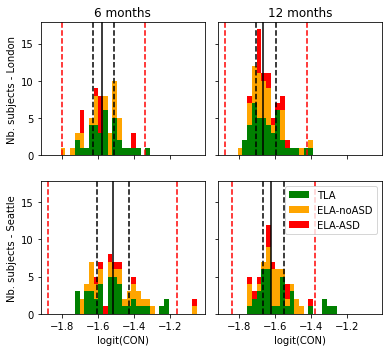

In [47]:
plot_outliers(dat)  

In [48]:
print("Nb recordings:", len(dat.groupby(["subject", "sex", "age", "group", "site"], observed=True).mean()))
print("Nb outliers:", len(outliers))


Nb recordings: 299
Nb outliers: 11


In [49]:
tmp = dat.groupby(["subject", "sex", "age", "group", "site"], observed=True).mean().reset_index()
for factor in ["age", "group", "site", "sex"]:
    nb_reject = outliers.groupby(factor).count()["subject"]
    nb_tot = tmp.groupby(factor).count()["subject"]


    print("; ".join([f"{key}: {nb_reject[key]}/{nb_tot[key]} ({val*100:.1f}%)" for key, val in (nb_reject/nb_tot).items()]))

6: 4/141 (2.8%); 12: 7/158 (4.4%)
Control: 7/149 (4.7%); HRA-noASD: 3/106 (2.8%); HRA-ASD: 1/44 (2.3%)
London: 5/157 (3.2%); Seattle: 6/142 (4.2%)
F: 8/146 (5.5%); M: 3/153 (2.0%)


In [50]:
outliers.groupby(factor).count()["subject"]

sex
F    8
M    3
Name: subject, dtype: int64

In [51]:
tmp.groupby(factor, observed=True).count()["subject"]

sex
F    146
M    153
Name: subject, dtype: int64

In [52]:
print_N(dat[(~dat.outliers_logit) & (dat.age != 18)])

age                   6      12
site    group                  
London  Control    11/21  20/21
        HRA-noASD   6/16   9/22
        HRA-ASD      9/2   10/5
Seattle Control    24/15  16/14
        HRA-noASD   20/6   19/5
        HRA-ASD      2/5    4/6

age,6,12
group,,
Control,35/36,36/35
HRA-noASD,26/22,28/27
HRA-ASD,11/7,14/11


In [53]:
# Average sample sizes
dat[(~dat.outliers_logit) & (dat.age != 18)].groupby(["subject", "group", "age"])\
    .mean().groupby("group").count()["con"]/2

group
Control      71.0
HRA-noASD    51.5
HRA-ASD      21.5
Name: con, dtype: float64

### Saving the processed dataset for further analysis

In [54]:
dat = dat[(~dat.outliers_logit) & (dat.age != 18)]
dat["log_con"] = logit(dat.con)

dat.to_csv("analysis_data.csv")

### Sample size comparison with literature

In [55]:
eeg_asd = [9, 10, 12, 87, 19, 15, 20, 430, 430, 72, 6, 16, 12, 12, 27, 14, 9, 21, 15, 27, 18, 10, 30, 5, 21, 34, 10]
eeg_control = [9, 10, 19, 29, 13, 15, 20, 554, 554, 31, 8, 17, 12, 19, 20, 19, 13, 16, 55, 18, 44, 46, 49, 21, 14]
eeg_total = [18, 74, 20, 31, 137, 32, 30, 40, 984, 984, 103, 14, 33, 24, 32, 47, 33, 22, 21, 31, 82, 36, 54, 105, 54, 42, 34, 24]

meg_asd = [14, 12, 16, 9, 26, 11, 17, 15, 35, 26, 50, 15, 10, 22, 20, 8, 8, 17, 16]
meg_control = [14, 35, 14, 10, 22, 11, 20, 20, 35, 26, 50, 15, 8, 17, 20, 8, 8, 20, 15]
meg_total = [28, 63, 30, 19, 48, 22, 37, 35, 70, 52, 100, 30, 18, 39, 40, 16, 16, 37, 31]


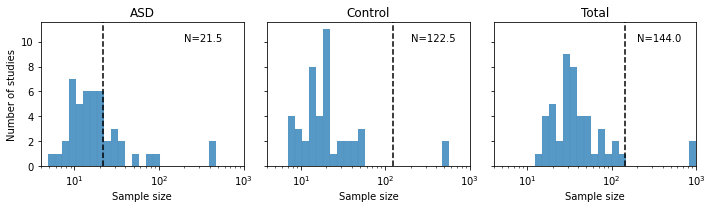

In [56]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3), sharex=True, sharey=True)

bins = 10**np.linspace(np.log10(4), np.log10(1000), 30)
sns.histplot(eeg_asd + meg_asd, label="asd", ax=axes[0], bins=bins)
sns.histplot(eeg_control + meg_control, label="control", ax=axes[1], bins=bins)
sns.histplot(eeg_total + meg_total, label="total", ax=axes[2], bins=bins)

axes[0].set_title("ASD")
axes[1].set_title("Control")
axes[2].set_title("Total")
axes[0].set_ylabel("Number of studies")
for ax in axes:
    ax.set_xscale('log')
    ax.set_xlim(4, 1000)
    ax.set_xlabel("Sample size")
    
# Total combined, average across time points, HRA- as control    
tmp = dat.groupby(["group", "site", "age", "subject"]).mean()\
         .groupby(["group", "site", "age"], observed=True).count()[["con"]].reset_index()
tmp = tmp[tmp.age != 18]
total_asd = tmp[tmp.group == "HRA-ASD"].groupby("site").mean()["con"].sum()
total_control = tmp[tmp.group != "HRA-ASD"].groupby(["group", "site"]).mean()["con"].sum()


axes[0].axvline(x=total_asd, color="k", linestyle="dashed")
axes[1].axvline(x=total_control, color="k", linestyle="dashed")
axes[2].axvline(x=total_asd + total_control, color="k", linestyle="dashed")
 
axes[0].text(200, 10, "N={}".format(total_asd), color="k")
axes[1].text(200, 10, "N={}".format(total_control), color="k")
axes[2].text(200, 10, "N={}".format(total_asd + total_control), color="k")

fig.tight_layout()

fig.savefig("images/" + "sample_size_hist.png", dpi=300)

In [57]:
x = np.array(eeg_asd + meg_asd)
print(np.sum(x <= 10)/len(x), np.sum(x <= 25)/len(x))

0.2391304347826087 0.7391304347826086
